In [45]:
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import numpy as np
import missingno as msno
import matplotlib.pyplot as plt
import scipy.stats as stats
from statsmodels.graphics.gofplots import qqplot
import seaborn as sns
from fancyimpute import IterativeImputer
from IPython.display import display
from scipy.stats import zscore
from scipy.stats import norm


from sys import path # modificar la lista de rutas de búsqueda que el intérprete de Python utiliza para buscar módulos y paquetes.
import os # interactua con el sistema operativo
for dirname, _, filenames in os.walk('../resources/'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
path.append(os.path.realpath('../'))

from custom import funtions

../resources/allColProSol.xlsx
../resources/dataset_a_2021.csv
../resources/dataset_a_2021v1.xlsx
../resources/dataset_unab_ORIGINAL SIN P1.csv
../resources/dataset_unab_P1.csv
../resources/exitoFallidoEnviosProgramaSol.xlsx
../resources/exitoFallidoProgramaSol.xlsx
../resources/exitosoFallidosEnviosAllColProSol.xlsx
../resources/exitosoFallidosEnviosAllColSol.xlsx
../resources/exitososFallidosEnviosSol.xlsx
../resources/Hito12sinColCeroExitosoFallidosSol.xlsx
../resources/sinColCeroExitosoFallidosEnviosSol.xlsx
../resources/sinColCeroExitosoFallidosSol.xlsx
../resources/v2_hitosExitoFalloColESol1.csv


In [46]:
# df = pd.read_excel(open('../resources/exitososFallidosEnviosSol.xlsx','rb'))
df = pd.read_csv("../resources/v2_hitosExitoFalloColESol1.csv", delimiter=";", skipinitialspace=True)
df.head()

,hito1,hito2,exitosos,fallidos,e0,e1,e2,e3,e4,e5,...,e44,e45,e46,e47,e48,e49,e50,e51,e52,sol1
0,17.0,0.0,10,21,1,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,1.0
1,12.0,0.0,7,9,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1.0
2,11.0,0.0,6,10,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1.0
3,0.0,0.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1.0
4,0.0,0.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1.0


In [47]:
df['aprobado']=df.apply(lambda x: funtions.set_in_aprobado_nota(x['sol1']),axis = 1 )
print(df.columns)

Index(['hito1', 'hito2', 'exitosos', 'fallidos', 'e0', 'e1', 'e2', 'e3', 'e4',
       'e5', 'e6', 'e7', 'e8', 'e9', 'e10', 'e11', 'e12', 'e13', 'e14', 'e15',
       'e16', 'e17', 'e18', 'e19', 'e20', 'e21', 'e22', 'e23', 'e24', 'e25',
       'e26', 'e27', 'e28', 'e29', 'e30', 'e31', 'e32', 'e33', 'e34', 'e35',
       'e36', 'e37', 'e38', 'e39', 'e40', 'e41', 'e42', 'e43', 'e44', 'e45',
       'e46', 'e47', 'e48', 'e49', 'e50', 'e51', 'e52', 'sol1', 'aprobado'],
      dtype='object')


In [48]:
# Dimensión del conjunto de datos
df.shape

(839, 59)

In [49]:
# Imprimir los n valores primeros segun su relevancia
df.tail()

,hito1,hito2,exitosos,fallidos,e0,e1,e2,e3,e4,e5,...,e45,e46,e47,e48,e49,e50,e51,e52,sol1,aprobado
834,20.0,0.0,11,5,1,0,0,1,1,0,...,0,0,0,0,0,0,0,0,7.0,1
835,14.0,0.0,9,7,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,7.0,1
836,20.0,0.0,11,20,1,0,0,1,1,0,...,0,0,0,0,0,0,0,0,7.0,1
837,32.0,0.0,16,15,1,0,0,1,1,0,...,0,0,0,0,0,0,0,0,7.0,1
838,4.0,0.0,2,29,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,7.0,1


In [50]:
# Imprimir la informacion de los datos.
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 839 entries, 0 to 838
Data columns (total 59 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   hito1     839 non-null    float64
 1   hito2     839 non-null    float64
 2   exitosos  839 non-null    int64  
 3   fallidos  839 non-null    int64  
 4   e0        839 non-null    int64  
 5   e1        839 non-null    int64  
 6   e2        839 non-null    int64  
 7   e3        839 non-null    int64  
 8   e4        839 non-null    int64  
 9   e5        839 non-null    int64  
 10  e6        839 non-null    int64  
 11  e7        839 non-null    int64  
 12  e8        839 non-null    int64  
 13  e9        839 non-null    int64  
 14  e10       839 non-null    int64  
 15  e11       839 non-null    int64  
 16  e12       839 non-null    int64  
 17  e13       839 non-null    int64  
 18  e14       839 non-null    int64  
 19  e15       839 non-null    int64  
 20  e16       839 non-null    int64 

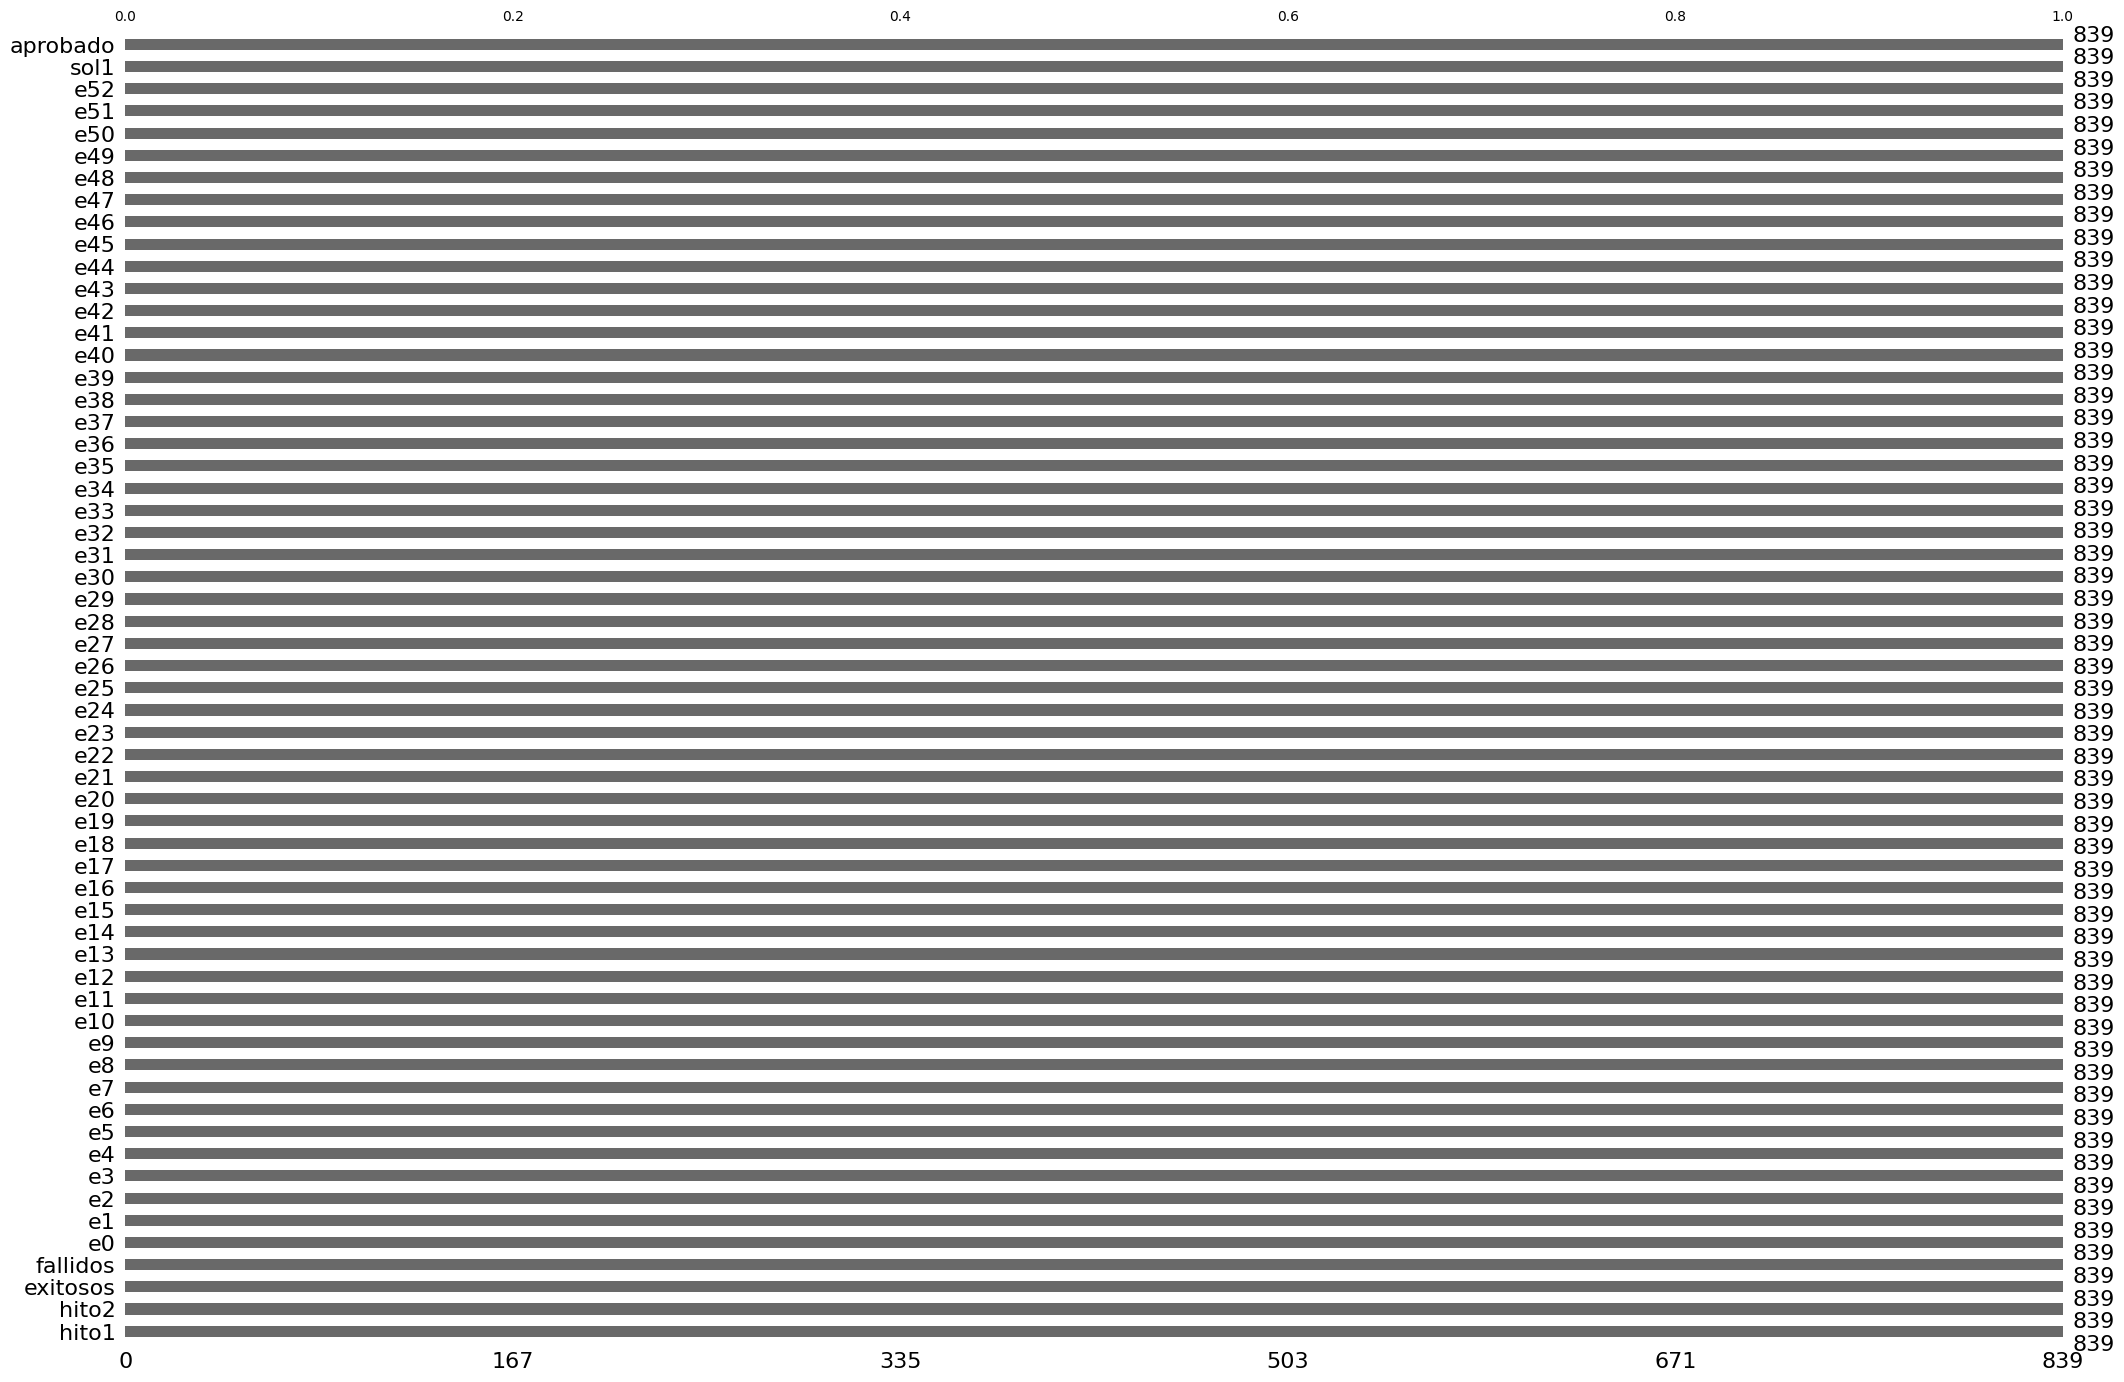

In [51]:
#Visualización de datos faltantes
vddf=msno.bar(df)
# Obtener la figura desde el objeto Axes
fig = vddf.get_figure()  

# Guardar la visualización de datos faltantes en un archivo PNG
#fig.savefig('E:\\dev\\tesis\\LaTeX\\img\\visualizacion_datos_faltantes.png')

In [52]:
# Análisis de variables numéricas
exitosos = df['sol1']
print(exitosos.describe())

def c_skew(x):
    x_mean = np.mean(x.dropna())
    x_std = np.std(x.dropna())
    m3 = np.mean((x.dropna() - x_mean) ** 3)
    skew = m3 / (x_std ** 3)
    return skew

skewness = c_skew(df['sol1'])
print('sesgo: ',skewness)
print("sesgo en porcentaje: {:.2f}%".format(skewness))

count    839.000000
mean       3.642789
std        1.832625
min        1.000000
25%        2.200000
50%        3.700000
75%        5.100000
max        7.000000
Name: sol1, dtype: float64
sesgo:  0.033079652062595215
sesgo en porcentaje: 0.03%


In [53]:
# Coeficiente de asimetría
def c_skew(x):
    m3 = np.mean((x - np.mean(x, axis=0)) ** 3, axis=0)
    skew = m3 / (np.std(x, axis=0) ** 3)
    skew_percent = skew * 100
    return skew, skew_percent
skewness, skewness_percent = c_skew(df['sol1'])
print("Coeficiente de asimetría:", skewness)
print("Coeficiente de asimetría en porcentaje: {:.2f}%".format(skewness_percent))

Coeficiente de asimetría: 0.033079652062595215
Coeficiente de asimetría en porcentaje: 3.31%


In [54]:
# Coeficiente de variación
def coef_var(x):
    std = np.std(x, axis=0)
    mean = np.mean(x, axis=0)
    cv = std / mean
    cv_percent = cv * 100
    return cv, cv_percent

cv, cv_percent = coef_var(df['sol1'])
print("Coeficiente de variación:", cv)
print("Coeficiente de variación en porcentaje: {:.2f}%".format(cv_percent))

Coeficiente de variación: 0.5027829289053924
Coeficiente de variación en porcentaje: 50.28%


In [55]:
# Eliminar filas con valores faltantes
data2 = df.dropna()

In [56]:
#Obteniendo amplitud
n = len(data2['sol1'])
amplitud = (np.nanmax(data2['sol1']) - np.nanmin(data2['sol1'])) / (1 + 3.322 * np.log10(n))
print('Amplitud: ', amplitud)
print("Amplitud en porcentaje: {:.2f}%".format(amplitud))

Amplitud:  0.5600809456082252
Amplitud en porcentaje: 0.56%


In [57]:
# Tabla de frecuencias
data2['sol1.cut'] = pd.cut(data2['sol1'], bins=np.arange(0, 7, 0.56))
f_i = data2['sol1.cut'].value_counts().sort_index().values
F_i = f_i.cumsum()
h_i = f_i / len(data2['sol1'])
H_i = F_i / len(data2['sol1'])

table = pd.DataFrame({'f_i': f_i, 'F_i': F_i, 'h_i': h_i, 'H_i': H_i}, index=data2['sol1.cut'].value_counts().sort_index().index)
display(table)


,f_i,F_i,h_i,H_i
"(0.0, 0.56]",0,0,0.000000,0.000000
"(0.56, 1.12]",152,152,0.181168,0.181168
"(1.12, 1.68]",21,173,0.025030,0.206198
"(1.68, 2.24]",66,239,0.078665,0.284863
"(2.24, 2.8]",79,318,0.094160,0.379023
"(2.8, 3.36]",34,352,0.040524,0.419547
"(3.36, 3.92]",103,455,0.122765,0.542312
"(3.92, 4.48]",76,531,0.090584,0.632896
"(4.48, 5.04]",87,618,0.103695,0.736591
"(5.04, 5.6]",81,699,0.096544,0.833135


In [58]:
mediana = np.median(data2['sol1'])
maximo = np.max(data2['sol1'])
intervalo_mediana = table.loc[table.index[np.where(np.cumsum(f_i) / np.sum(f_i) >= 0.5)[0][0]]]
intervalo_maximo = table.loc[table.index[-1]]
print("Mediana:", mediana)
print("Intervalo de la mediana:", intervalo_mediana)
print("Máximo:", maximo)
print("Intervalo del máximo:", intervalo_maximo)


Mediana: 3.7
Intervalo de la mediana: f_i    103.000000
F_i    455.000000
h_i      0.122765
H_i      0.542312
Name: (3.36, 3.92], dtype: float64
Máximo: 7.0
Intervalo del máximo: f_i     57.000000
F_i    809.000000
h_i      0.067938
H_i      0.964243
Name: (6.16, 6.72], dtype: float64


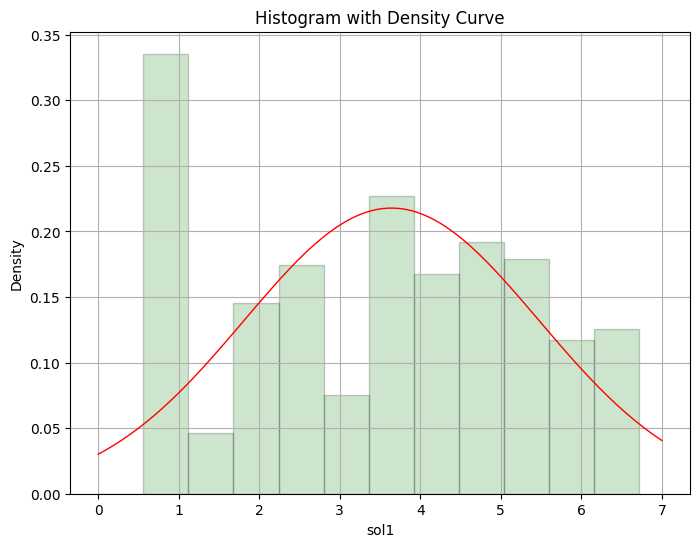

In [59]:
# Histograma con curva de densidad
plt.figure(figsize=(8, 6))
plt.hist(data2['sol1'], bins=np.arange(0, 7, 0.56), density=True, color='green', alpha=0.2, edgecolor='black')
mu = np.mean(data2['sol1'])
sigma = np.std(data2['sol1'])
x = np.linspace(0, 7, 100)
plt.plot(x, norm.pdf(x, mu, sigma), color='red', linewidth=1)
plt.xlabel('sol1')
plt.ylabel('Density')
plt.title('Histogram with Density Curve')
plt.grid(True)
plt.show()
#plt.savefig('E:\\dev\\tesis\\LaTeX\\img\\histogramaConCurvaDeDensidad.png')

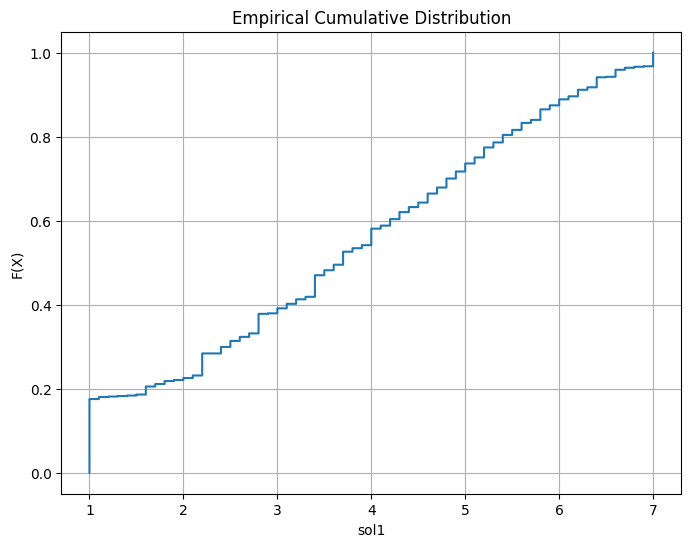

In [60]:
# Distribución empírica acumulada
plt.figure(figsize=(8, 6))
plt.step(np.sort(data2['sol1']), np.arange(1, len(data2['sol1']) + 1) / len(data2['sol1']), where='post')
plt.xlabel('sol1')
plt.ylabel('F(X)')
plt.title('Empirical Cumulative Distribution')
plt.grid(True)
plt.show()
#plt.savefig('E:\\dev\\tesis\\LaTeX\\img\\DistribucionEmpiricaAcumulada.png')

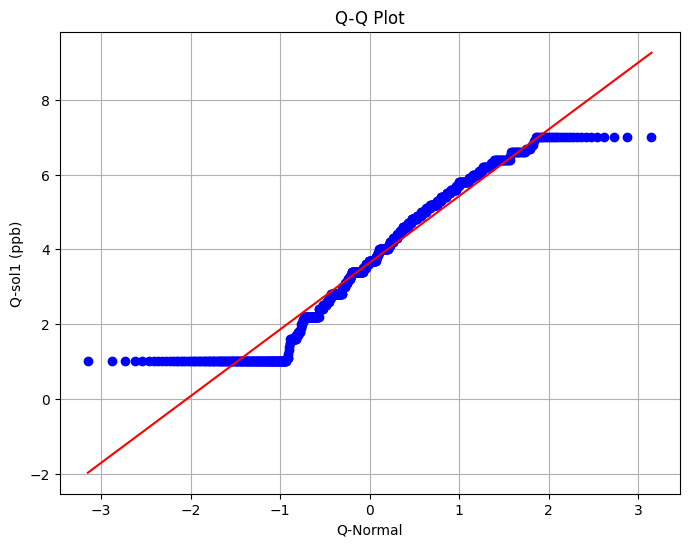

In [61]:
# Q-Q plot
plt.figure(figsize=(8, 6))
stats.probplot(data2['sol1'], dist="norm", plot=plt)
plt.xlabel('Q-Normal')
plt.ylabel('Q-sol1 (ppb)')
plt.title('Q-Q Plot')
plt.grid(True)
plt.show()
#plt.savefig('E:\\dev\\tesis\\LaTeX\\img\\QQPlot.png')

In [62]:
# Prueba de normalidad
kstest_result = stats.kstest(data2['sol1'], 'norm', args=(np.mean(data2['sol1']), np.std(data2['sol1'])))
shapiro_result = stats.shapiro(data2['sol1'])
display('KS test p-value:', kstest_result.pvalue)
display('Shapiro-Wilk test p-value:', shapiro_result.pvalue)

'KS test p-value:'

4.9160914226959916e-08

'Shapiro-Wilk test p-value:'

1.9616962112331925e-17

In [63]:
# Calcular estadísticos descriptivos
stats = df.describe()

# Calcular límites para detectar valores atípicos (ejemplo: utilizando el rango intercuartil)
Q1 = stats.loc['25%']
Q3 = stats.loc['75%']
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Identificar valores atípicos
outliers = df[(df < lower_bound) | (df > upper_bound)]
display(outliers)

,hito1,hito2,exitosos,fallidos,e0,e1,e2,e3,e4,e5,...,e45,e46,e47,e48,e49,e50,e51,e52,sol1,aprobado
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
834,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
835,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
836,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
837,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [64]:
# Calcular el Z-score de cada observación
z_scores = zscore(df)

# Establecer un umbral para detectar valores atípicos (ejemplo: umbral de 3 desviaciones estándar)
threshold = 3

# Identificar valores atípicos
outliers = df[(z_scores > threshold).any(axis=1)]
display(outliers)

,hito1,hito2,exitosos,fallidos,e0,e1,e2,e3,e4,e5,...,e45,e46,e47,e48,e49,e50,e51,e52,sol1,aprobado
60,21.0,6.0,17,14,1,0,0,1,1,0,...,0,0,0,0,0,0,0,0,1.0,0
68,2.0,2.0,4,27,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1.0,0
156,4.0,4.0,6,41,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1.5,0
163,0.0,0.0,0,47,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1.6,0
164,10.0,6.0,9,38,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,1.6,0
249,12.0,0.0,9,38,1,0,0,1,1,0,...,0,0,0,0,0,0,0,0,2.4,0
262,42.0,12.0,26,37,1,1,0,1,1,0,...,0,0,0,0,0,0,0,0,2.5,0
370,32.0,32.0,26,5,1,1,0,1,1,0,...,0,0,0,0,0,0,0,0,3.4,0
514,9.0,0.0,7,40,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,4.3,1
523,38.0,6.0,28,35,1,1,0,1,1,0,...,0,0,0,0,0,0,0,0,4.4,1


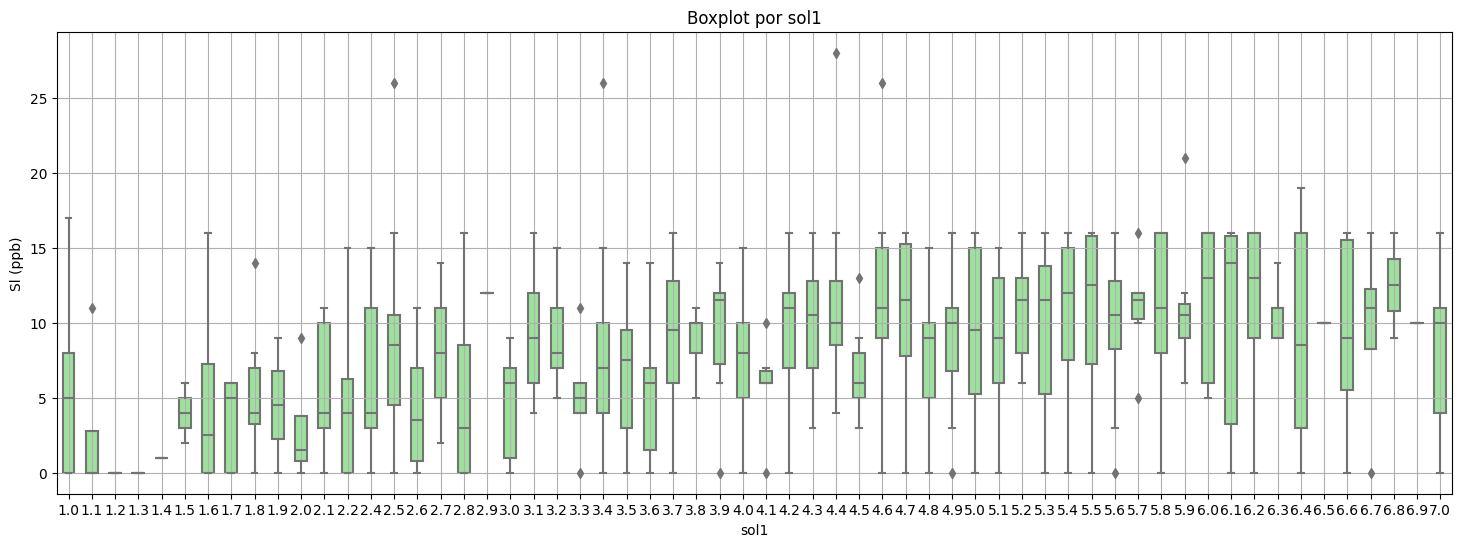

In [70]:
# Boxplot por sol1
plt.figure(figsize=(18, 6))
sns.boxplot(data=data2, x='sol1', y='exitosos', color='lightgreen', width=0.5)
plt.xlabel('sol1')
plt.ylabel('Sl (ppb)')
plt.title('Boxplot por sol1')
plt.grid(True)
plt.show()
#plt.savefig('E:\\dev\\tesis\\LaTeX\\img\\BoxplotPorsol1.png')

In [66]:
# Análisis e imputación de datos faltantes
# missing_data = data2.isnull().sum()
# missing_data_table = pd.DataFrame({'Variable': missing_data.index, 'Missing Count': missing_data.values})
# display(missing_data_table)

In [67]:
# Imputar valores perdidos con la estrategia del promedio
# df_imputed = df.fillna(df.mean())
# display(df_imputed)